# 01_Preprocessing - ECG Arrhythmia Classification

## 📋 Description

This notebook serves as the main data processing pipeline for **Phase 1** of the ECG Arrhythmia Classification project.

### Workflow Steps:

1. **Download Data**: Fetch a specified record from the MIT-BIH Arrhythmia Database
2. **Extract Signal**: Load raw ECG signal ('MLII' lead) and expert annotations
3. **Filter Beats**: Select a specific beat type (default: 'N' - Normal)
4. **Segment Signal**: Split continuous signal into individual heartbeats
5. **Feature Extraction**: Apply and compare three distinct methods:
   - **Method 1**: Raw Resampled Waveform (360 features)
   - **Method 2**: Handcrafted Features - RR-Intervals, Amplitude (3 features)
   - **Method 3**: Wavelet Transform Statistics (16 features)

---

## 🎯 Objectives

- Process MIT-BIH ECG data for machine learning
- Compare different feature extraction approaches
- Generate visualizations for analysis
- Prepare data foundation for Phase 2 (Model Development)

---

## 📊 Output

This notebook generates multiple plots saved to `report_images/` directory:
- Raw signal visualization
- Filtered signal
- Feature extraction comparisons
- Beat segmentation examples

---

## 👤 Author

**Author**: [Dev Bansal]  
**Date**: [18/11/2025]  
**Project**: ECG Arrhythmia Classification - Phase 1

---

## 🚀 Quick Start

Simply run all cells in sequence. The notebook will:
- Automatically download Record 100 from PhysioNet
- Process all 'N' (Normal) beats
- Generate comprehensive visualizations

# Step 1: Setup and Database Download
Install required libraries and download MIT-BIH database

In [2]:
# Install required libraries
!pip install wfdb scipy numpy matplotlib pandas

# Import libraries
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal
import os

# Download single record (100) from MIT-BIH database
record_name = '100'
record = wfdb.rdrecord(record_name, pn_dir='mitdb')
annotation = wfdb.rdann(record_name, 'atr', pn_dir='mitdb')

print(f"✓ Record {record_name} downloaded successfully")
print(f"  Sampling Frequency: {record.fs} Hz")
print(f"  Signal Length: {record.sig_len} samples")
print(f"  Duration: {record.sig_len / record.fs / 60:.2f} minutes")
print(f"  Channels: {record.sig_name}")
print(f"  Total Annotations: {len(annotation.sample)} beats")

  Using cached wfdb-4.3.0-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 101.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
✓ Record 100 downloaded successfully
  Sampling Frequency: 360 Hz
  Signal Length: 650000 samples
  Duration: 30.09 minutes
  Channels: ['MLII', 'V5']
  Total Annotations: 2274 beats


# Step 2: Extract Signal and Annotations
Load MLII signal and R-peak locations

✓ Signal extracted
  Signal shape: (650000,)
  Number of R-peaks detected: 2274
  Beat types found: {'+', 'N', 'A', 'V'}


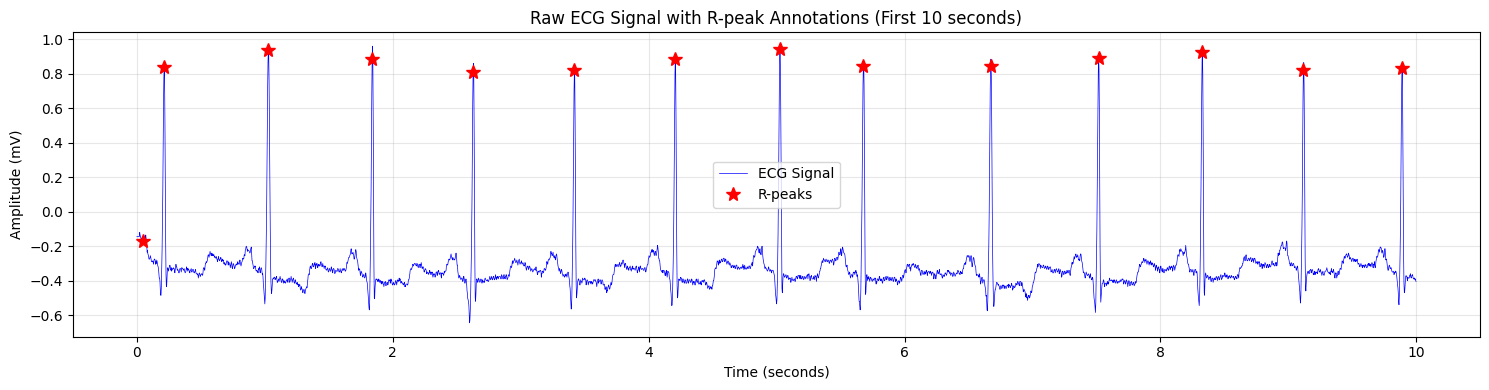

In [3]:
# Extract MLII signal (channel 0)
signal_data = record.p_signal[:, 0]  # MLII lead
fs = record.fs  # 360 Hz

# Extract R-peak locations and beat types
r_peaks = annotation.sample
beat_types = annotation.symbol

print(f"✓ Signal extracted")
print(f"  Signal shape: {signal_data.shape}")
print(f"  Number of R-peaks detected: {len(r_peaks)}")
print(f"  Beat types found: {set(beat_types)}")

# Visualize raw signal with R-peaks
plt.figure(figsize=(15, 4))
time_axis = np.arange(len(signal_data)) / fs
plt.plot(time_axis[:3600], signal_data[:3600], 'b-', linewidth=0.5, label='ECG Signal')
r_peaks_in_window = r_peaks[r_peaks < 3600]
plt.plot(r_peaks_in_window / fs, signal_data[r_peaks_in_window], 'r*',
         markersize=10, label='R-peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (mV)')
plt.title('Raw ECG Signal with R-peak Annotations (First 10 seconds)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 3: Select Normal Beats Only
Filter for 'N' (Normal) beats for preprocessing

In [4]:
# Filter only Normal beats (symbol 'N')
normal_indices = [i for i, symbol in enumerate(beat_types) if symbol == 'N']
normal_r_peaks = r_peaks[normal_indices]

print(f"✓ Filtering complete")
print(f"  Total beats: {len(r_peaks)}")
print(f"  Normal beats: {len(normal_r_peaks)}")
print(f"  Percentage: {len(normal_r_peaks)/len(r_peaks)*100:.1f}%")

# Remove edge beats (first and last to avoid boundary issues)
normal_r_peaks = normal_r_peaks[1:-1]
print(f"  Beats after removing edges: {len(normal_r_peaks)}")

✓ Filtering complete
  Total beats: 2274
  Normal beats: 2239
  Percentage: 98.5%
  Beats after removing edges: 2237


# Step 4: Segment Beats
Extract individual heartbeats around R-peaks

✓ Segmentation complete
  Segments extracted: 2237
  Segment shape: (2237, 216)
  Each segment: 216 samples (600.0 ms)


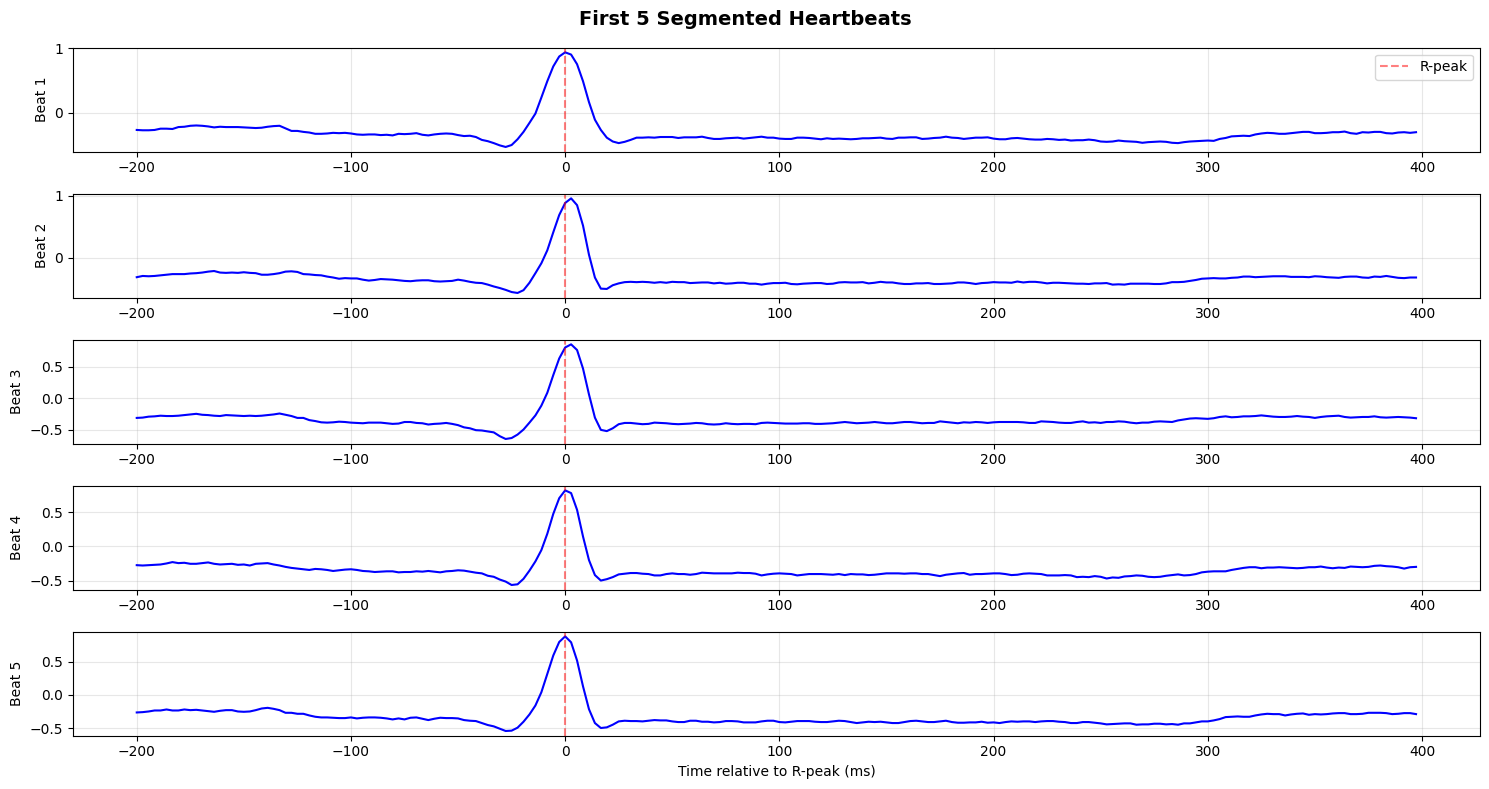

In [5]:
# Define segmentation window
before_r = int(0.2 * fs)  # 200ms before R-peak (72 samples)
after_r = int(0.4 * fs)   # 400ms after R-peak (144 samples)
segment_length = before_r + after_r  # 216 samples total

# Extract all valid segments
segments = []
valid_r_peaks = []

for r_peak in normal_r_peaks:
    start = r_peak - before_r
    end = r_peak + after_r

    # Check boundaries
    if start >= 0 and end < len(signal_data):
        segment = signal_data[start:end]
        if len(segment) == segment_length:
            segments.append(segment)
            valid_r_peaks.append(r_peak)

segments = np.array(segments)
print(f"✓ Segmentation complete")
print(f"  Segments extracted: {len(segments)}")
print(f"  Segment shape: {segments.shape}")
print(f"  Each segment: {segment_length} samples ({segment_length/fs*1000:.1f} ms)")

# Visualize first 5 segments
plt.figure(figsize=(15, 8))
time_segment = (np.arange(segment_length) - before_r) / fs * 1000  # in ms

for i in range(min(5, len(segments))):
    plt.subplot(5, 1, i+1)
    plt.plot(time_segment, segments[i], 'b-', linewidth=1.5)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='R-peak')
    plt.ylabel(f'Beat {i+1}')
    plt.grid(True, alpha=0.3)
    if i == 0:
        plt.legend()
    if i == 4:
        plt.xlabel('Time relative to R-peak (ms)')

plt.suptitle('First 5 Segmented Heartbeats', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# METHOD 1: Raw Waveform (360 samples)
Convert signal to fixed-length raw values

METHOD 1: RAW WAVEFORM SEGMENTATION
✓ Conversion complete
  Input:  2237 segments × 216 samples
  Output: 2237 segments × 360 values
  Feature vector per beat: 360 raw voltage values


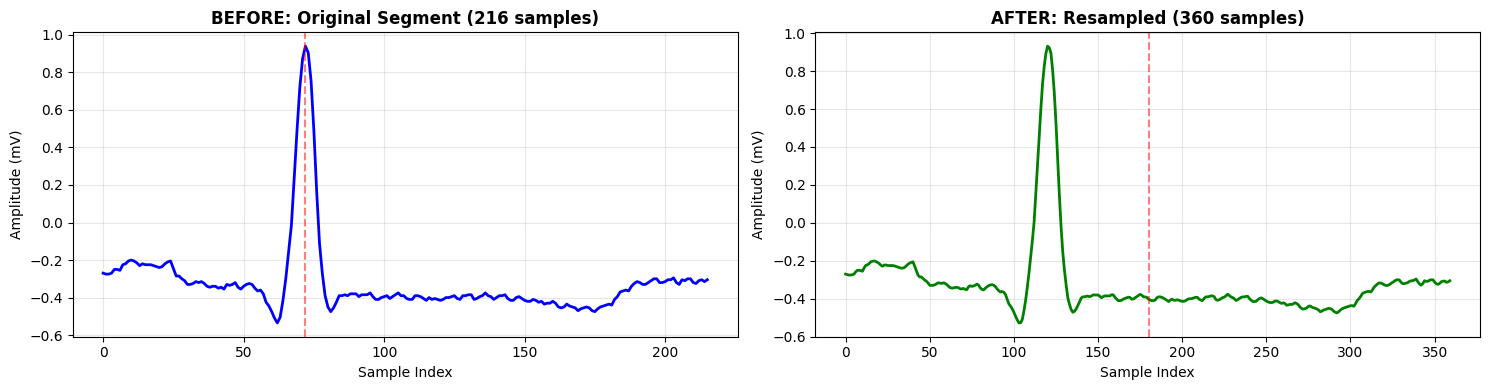


📊 Example: Beat #1
  Original values (first 10): [-0.27  -0.275 -0.275 -0.27  -0.25  -0.25  -0.255 -0.225 -0.22  -0.205]
  Resampled values (first 10): [-0.27       -0.27299443 -0.275      -0.275      -0.27302228 -0.27002786
 -0.2581337  -0.25       -0.25       -0.25194986]


In [6]:
# Resample each segment to exactly 360 samples
from scipy.interpolate import interp1d

def resample_segment(segment, target_length=360):
    original_length = len(segment)
    x_original = np.linspace(0, 1, original_length)
    x_target = np.linspace(0, 1, target_length)
    interpolator = interp1d(x_original, segment, kind='linear')
    return interpolator(x_target)

# Apply to all segments
method1_features = np.array([resample_segment(seg, 360) for seg in segments])

print("="*60)
print("METHOD 1: RAW WAVEFORM SEGMENTATION")
print("="*60)
print(f"✓ Conversion complete")
print(f"  Input:  {segments.shape[0]} segments × {segments.shape[1]} samples")
print(f"  Output: {method1_features.shape[0]} segments × {method1_features.shape[1]} values")
print(f"  Feature vector per beat: {method1_features.shape[1]} raw voltage values")

# Show BEFORE and AFTER for one beat
beat_idx = 0
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# BEFORE: Original segment
axes[0].plot(segments[beat_idx], 'b-', linewidth=2)
axes[0].axvline(x=before_r, color='r', linestyle='--', alpha=0.5)
axes[0].set_title(f'BEFORE: Original Segment ({len(segments[beat_idx])} samples)',
                  fontweight='bold')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Amplitude (mV)')
axes[0].grid(True, alpha=0.3)

# AFTER: Resampled to 360
axes[1].plot(method1_features[beat_idx], 'g-', linewidth=2)
axes[1].axvline(x=180, color='r', linestyle='--', alpha=0.5)
axes[1].set_title(f'AFTER: Resampled ({len(method1_features[beat_idx])} samples)',
                  fontweight='bold')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Amplitude (mV)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Example: Beat #{beat_idx+1}")
print(f"  Original values (first 10): {segments[beat_idx][:10]}")
print(f"  Resampled values (first 10): {method1_features[beat_idx][:10]}")

# METHOD 2: Handcrafted Features (3 values)
Extract RR-intervals and R-peak amplitude

METHOD 2: HANDCRAFTED FEATURES (MORPHOLOGICAL + TEMPORAL)
✓ Conversion complete
  Input:  2237 raw signal segments
  Output: 2235 segments × 3 features
  Features: [Pre-RR (ms), Post-RR (ms), R-amplitude (mV)]


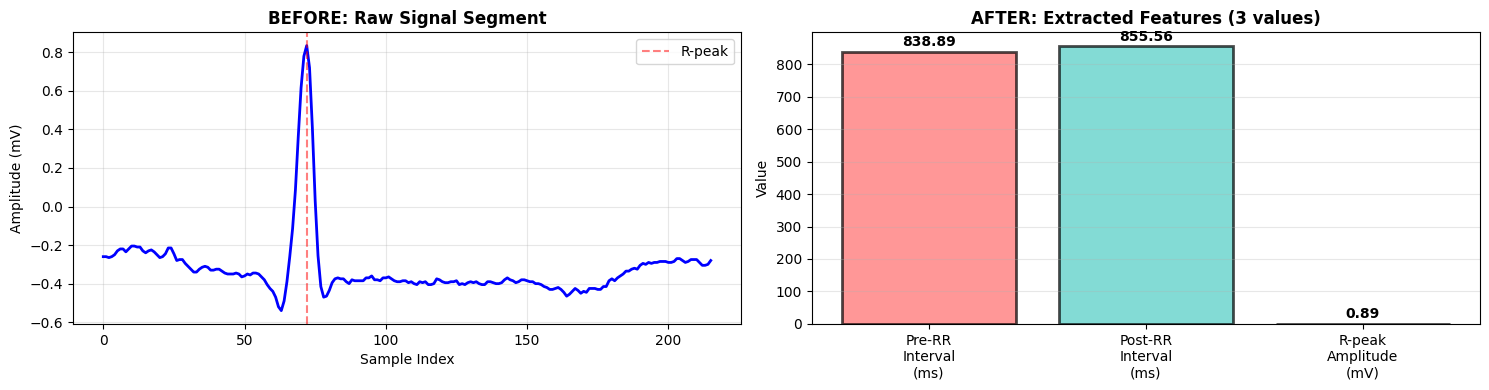


📊 Example: Beat #11
  Pre-RR interval:  838.89 ms
  Post-RR interval: 855.56 ms
  R-amplitude:      0.8850 mV


In [7]:
# Calculate RR-intervals and R-peak amplitudes
def extract_handcrafted_features(r_peaks, signal_data, fs):
    features = []

    for i in range(1, len(r_peaks) - 1):
        # Pre-RR interval (time between previous and current beat)
        pre_rr = (r_peaks[i] - r_peaks[i-1]) / fs * 1000  # in ms

        # Post-RR interval (time between current and next beat)
        post_rr = (r_peaks[i+1] - r_peaks[i]) / fs * 1000  # in ms

        # R-peak amplitude
        r_amplitude = signal_data[r_peaks[i]]

        features.append([pre_rr, post_rr, r_amplitude])

    return np.array(features)

method2_features = extract_handcrafted_features(valid_r_peaks, signal_data, fs)

print("="*60)
print("METHOD 2: HANDCRAFTED FEATURES (MORPHOLOGICAL + TEMPORAL)")
print("="*60)
print(f"✓ Conversion complete")
print(f"  Input:  {len(segments)} raw signal segments")
print(f"  Output: {method2_features.shape[0]} segments × {method2_features.shape[1]} features")
print(f"  Features: [Pre-RR (ms), Post-RR (ms), R-amplitude (mV)]")

# Show BEFORE and AFTER
beat_idx = 10
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# BEFORE: Raw signal segment
axes[0].plot(segments[beat_idx], 'b-', linewidth=2)
axes[0].axvline(x=before_r, color='r', linestyle='--', alpha=0.5, label='R-peak')
axes[0].set_title('BEFORE: Raw Signal Segment', fontweight='bold')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Amplitude (mV)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# AFTER: 3 extracted features
features = method2_features[beat_idx]
feature_names = ['Pre-RR\nInterval\n(ms)', 'Post-RR\nInterval\n(ms)',
                 'R-peak\nAmplitude\n(mV)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
axes[1].bar(feature_names, features, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_title('AFTER: Extracted Features (3 values)', fontweight='bold')
axes[1].set_ylabel('Value')
axes[1].grid(True, alpha=0.3, axis='y')

for i, (name, val) in enumerate(zip(feature_names, features)):
    axes[1].text(i, val + max(features)*0.02, f'{val:.2f}',
                ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Example: Beat #{beat_idx+1}")
print(f"  Pre-RR interval:  {features[0]:.2f} ms")
print(f"  Post-RR interval: {features[1]:.2f} ms")
print(f"  R-amplitude:      {features[2]:.4f} mV")

# METHOD 3: Wavelet Transform (16 values)
Extract frequency-domain features using DWT

METHOD 3: WAVELET TRANSFORM FEATURES (FREQUENCY ANALYSIS)
✓ Conversion complete
  Input:  2237 raw signal segments
  Output: 2237 segments × 16 features
  Wavelet used: Daubechies-4 (db4)
  Decomposition levels: 3
  Features per level: [Mean, Std, Max, Energy] × 4 levels = 16 features


/tmp/ipython-input-3306014751.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


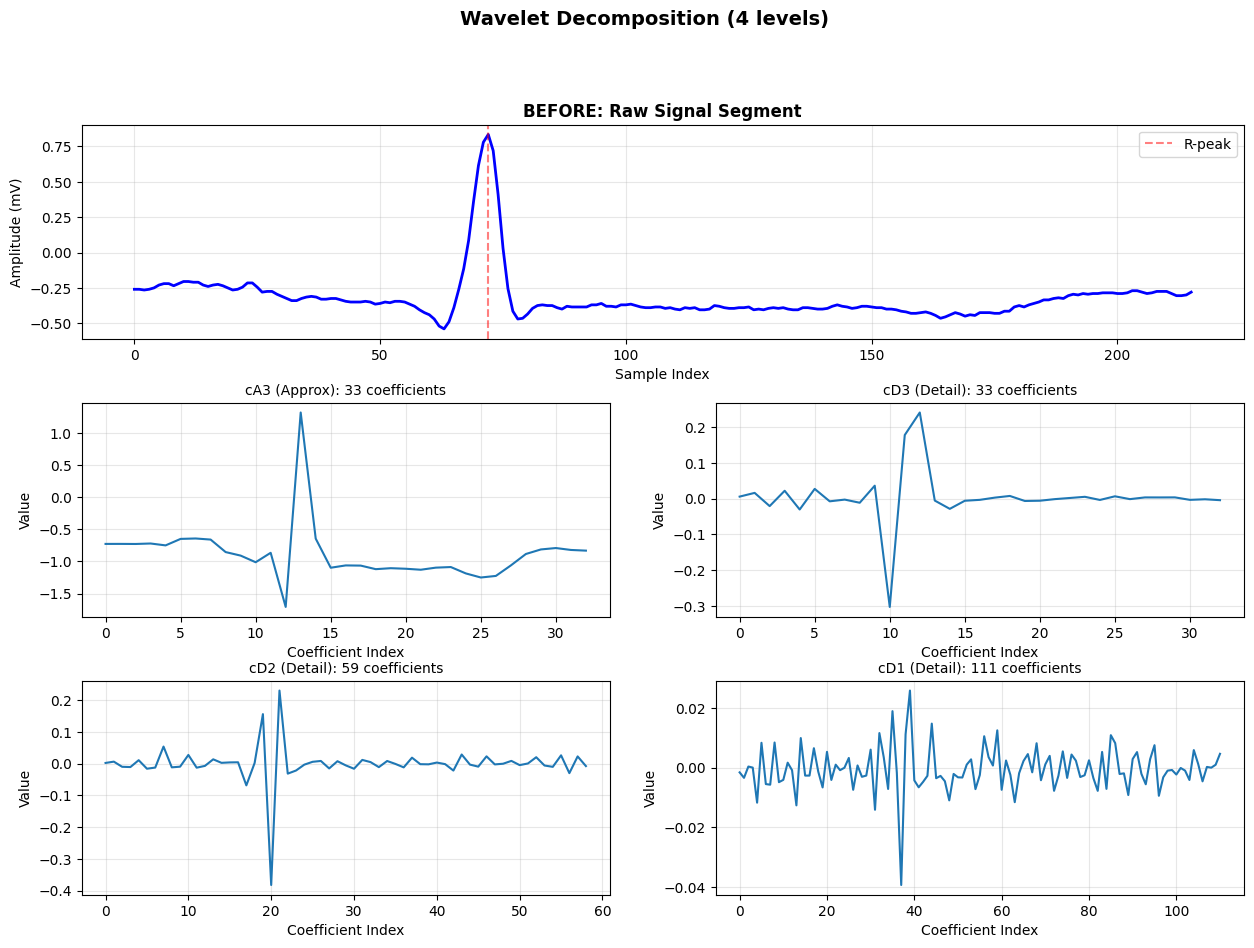

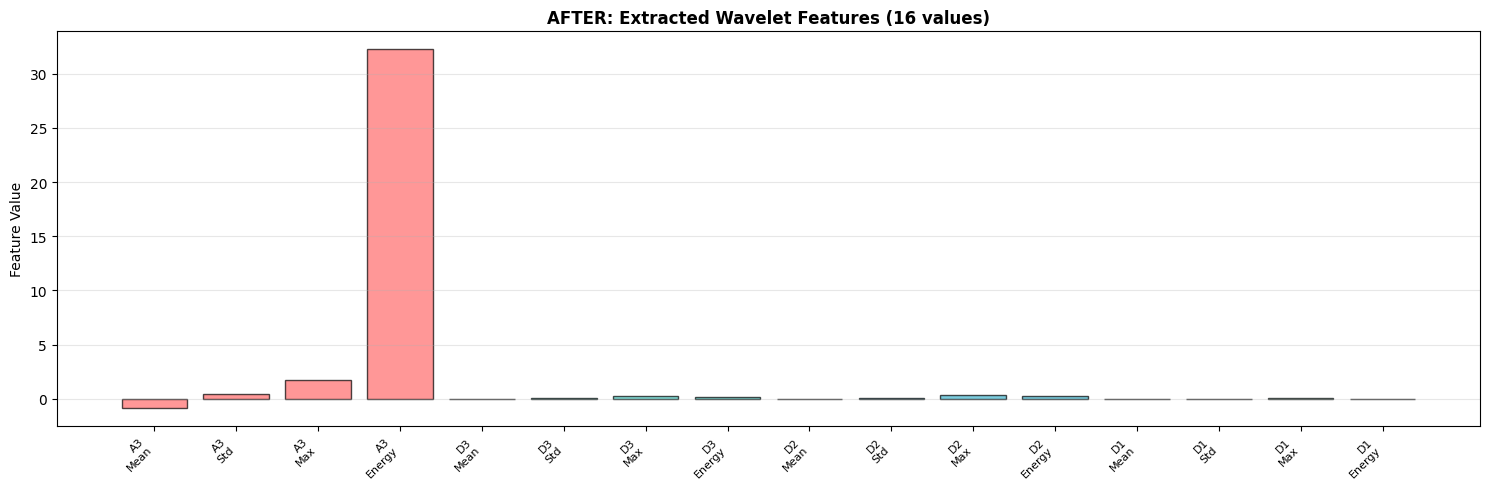


📊 Example: Beat #11
  Feature vector: [-8.79742592e-01  4.50689920e-01  1.70906341e+00  3.22432583e+01
  3.12630786e-03  7.51023059e-02  3.02783765e-01  1.86454295e-01]
  (Showing first 8 of 16 features)


In [ ]:
# Apply Discrete Wavelet Transform
def extract_wavelet_features(segment, wavelet='db4', level=3):
    coeffs = pywt.wavedec(segment, wavelet, level=level)
    features = []

    # Extract statistics from each level
    for coeff in coeffs:
        features.extend([
            np.mean(coeff),      # Mean
            np.std(coeff),       # Standard deviation
            np.max(np.abs(coeff)), # Max absolute value
            np.sum(coeff**2)     # Energy
        ])

    return np.array(features)

method3_features = np.array([extract_wavelet_features(seg) for seg in segments])

print("="*60)
print("METHOD 3: WAVELET TRANSFORM FEATURES (FREQUENCY ANALYSIS)")
print("="*60)
print(f"✓ Conversion complete")
print(f"  Input:  {len(segments)} raw signal segments")
print(f"  Output: {method3_features.shape[0]} segments × {method3_features.shape[1]} features")
print(f"  Wavelet used: Daubechies-4 (db4)")
print(f"  Decomposition levels: 3")
print(f"  Features per level: [Mean, Std, Max, Energy] × 4 levels = 16 features")

# Show BEFORE and AFTER
beat_idx = 10
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3)

# BEFORE: Raw signal
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(segments[beat_idx], 'b-', linewidth=2)
ax1.axvline(x=before_r, color='r', linestyle='--', alpha=0.5, label='R-peak')
ax1.set_title('BEFORE: Raw Signal Segment', fontweight='bold', fontsize=12)
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Amplitude (mV)')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.savefig('raw_signal_segment.png') # Save the raw signal segment plot

# Wavelet decomposition visualization
coeffs = pywt.wavedec(segments[beat_idx], 'db4', level=3)
level_names = ['cA3 (Approx)', 'cD3 (Detail)', 'cD2 (Detail)', 'cD1 (Detail)']

for i, (coeff, name) in enumerate(zip(coeffs, level_names)):
    ax = fig.add_subplot(gs[1 + i//2, i%2])
    ax.plot(coeff, linewidth=1.5)
    ax.set_title(f'{name}: {len(coeff)} coefficients', fontsize=10)
    ax.set_xlabel('Coefficient Index')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.suptitle('Wavelet Decomposition (4 levels)', fontweight='bold', fontsize=14, y=0.995)
plt.tight_layout()
plt.savefig('wavelet_decomposition.png') # Save the wavelet decomposition plot
plt.show()

# AFTER: Extracted features
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
features = method3_features[beat_idx]
feature_labels = []
for i, level in enumerate(['A3', 'D3', 'D2', 'D1']):
    feature_labels.extend([f'{level}\nMean', f'{level}\nStd',
                          f'{level}\nMax', f'{level}\nEnergy'])

colors = ['#FF6B6B']*4 + ['#4ECDC4']*4 + ['#45B7D1']*4 + ['#95E1D3']*4
axes.bar(range(len(features)), features, color=colors, alpha=0.7,
         edgecolor='black', linewidth=1)
axes.set_xticks(range(len(features)))
axes.set_xticklabels(feature_labels, rotation=45, ha='right', fontsize=8)
axes.set_title('AFTER: Extracted Wavelet Features (16 values)', fontweight='bold')
axes.set_ylabel('Feature Value')
axes.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('extracted_wavelet_features.png') # Save the extracted features plot
plt.show()

print(f"\n📊 Example: Beat #{beat_idx+1}")
print(f"  Feature vector: {features[:8]}")  # Show first 8
print(f"  (Showing first 8 of {len(features)} features)")


# Step 5: Comparison Summary
Compare all three methods side-by-side

COMPARISON OF ALL THREE METHODS
                Method  Features per Beat  Total Beats                                      Description                                             Advantages                               Best For
Method 1: Raw Waveform                360         2237             Raw voltage values (shape preserved)       Complete signal information, no information loss      Deep learning models (CNNs, RNNs)
 Method 2: Handcrafted                  3         2235 RR-intervals + R-amplitude (timing + morphology) Very small, interpretable, captures key cardiac timing Simple ML models, real-time processing
     Method 3: Wavelet                 16           16        Frequency components (wavelet statistics)           Captures frequency patterns, robust to noise    Traditional ML (SVM, Random Forest)


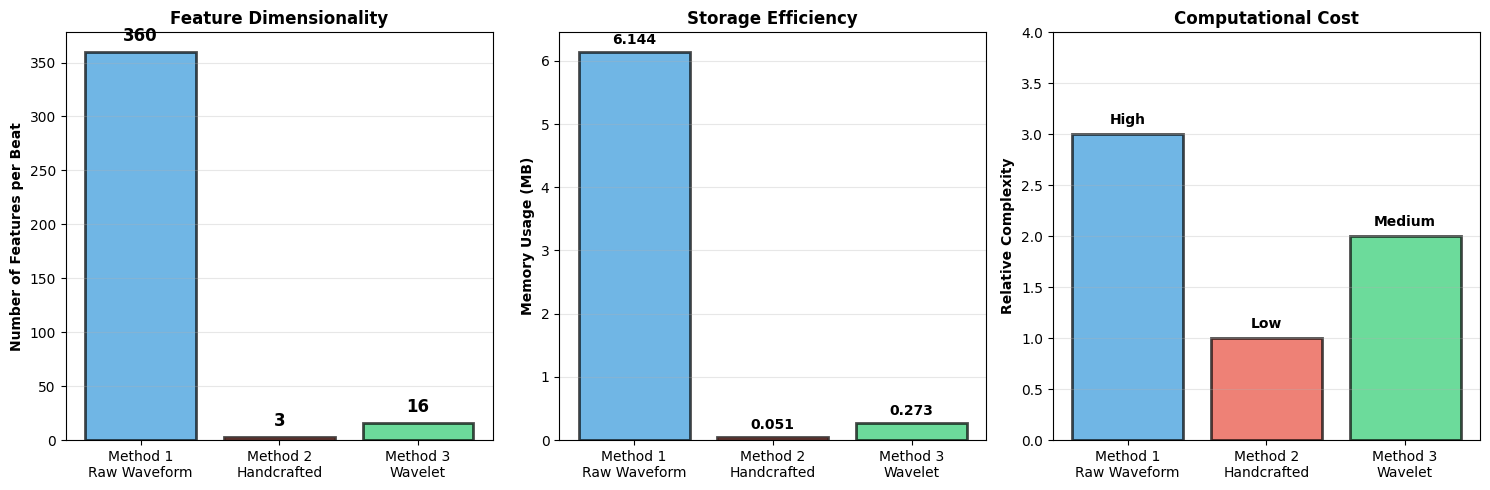


✓ All preprocessing methods completed successfully!


In [ ]:
import pandas as pd

# Create comparison table
comparison = pd.DataFrame({
    'Method': ['Method 1: Raw Waveform',
               'Method 2: Handcrafted',
               'Method 3: Wavelet'],
    'Features per Beat': [method1_features.shape[1],
                          method2_features.shape[1],
                          method3_features.shape[1]],
    'Total Beats': [method1_features.shape[0],
                    method2_features.shape[0],
                    method3_features.shape[1]],
    'Description': ['Raw voltage values (shape preserved)',
                    'RR-intervals + R-amplitude (timing + morphology)',
                    'Frequency components (wavelet statistics)'],
    'Advantages': ['Complete signal information, no information loss',
                   'Very small, interpretable, captures key cardiac timing',
                   'Captures frequency patterns, robust to noise'],
    'Best For': ['Deep learning models (CNNs, RNNs)',
                 'Simple ML models, real-time processing',
                 'Traditional ML (SVM, Random Forest)']
})

print("="*80)
print("COMPARISON OF ALL THREE METHODS")
print("="*80)
print(comparison.to_string(index=False))

# Visualization: Feature count comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

methods = ['Method 1\nRaw Waveform', 'Method 2\nHandcrafted', 'Method 3\nWavelet']
feature_counts = [method1_features.shape[1], method2_features.shape[1],
                  method3_features.shape[1]]
colors_bar = ['#3498db', '#e74c3c', '#2ecc71']

# Bar chart
axes[0].bar(methods, feature_counts, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Number of Features per Beat', fontweight='bold')
axes[0].set_title('Feature Dimensionality', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for i, (m, fc) in enumerate(zip(methods, feature_counts)):
    axes[0].text(i, fc + 10, str(fc), ha='center', fontweight='bold', fontsize=12)

# Memory usage comparison (approximate)
memory_mb = [method1_features.nbytes / 1024 / 1024,
             method2_features.nbytes / 1024 / 1024,
             method3_features.nbytes / 1024 / 1024]

axes[1].bar(methods, memory_mb, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Memory Usage (MB)', fontweight='bold')
axes[1].set_title('Storage Efficiency', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for i, (m, mem) in enumerate(zip(methods, memory_mb)):
    axes[1].text(i, mem + max(memory_mb)*0.02, f'{mem:.3f}', ha='center',
                fontweight='bold', fontsize=10)

# Processing complexity (relative scale)
complexity = [3, 1, 2]  # Relative complexity
axes[2].bar(methods, complexity, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
axes[2].set_ylabel('Relative Complexity', fontweight='bold')
axes[2].set_title('Computational Cost', fontweight='bold')
axes[2].set_ylim(0, 4)
axes[2].grid(True, alpha=0.3, axis='y')
complexity_labels = ['Low', 'Medium', 'High']
for i, (m, c) in enumerate(zip(methods, complexity)):
    axes[2].text(i, c + 0.1, complexity_labels[c-1], ha='center',
                fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ All preprocessing methods completed successfully!")
print("="*80)

1. It Clearly Shows "Signal to Individual Beats" (Cell 4)
This is the "cookie cutter" step we talked about.

Before: You had one long, 30-minute signal.

After (Cell 4): You now have a dataset of 2,237 individual heartbeats, where each one is a 216-sample-long "clip."

Segment shape: (2237, 216): This is the most important output. You now have a clean X data matrix, ready for feature extraction.

2. It Shows 3 Ways to "Transform Beats to Values" (Cells 5, 6, 7)
This is the "values" part of your question. The code shows you three distinct strategies.

Method 1: The Raw Values (Cell 5)
This method says, "The shape itself is the feature."

What it does: It just resamples each 216-sample beat to a standard length of 360.

Why it's useful: This is exactly what you use for a CNN. Your CNN-LSTM model is designed to learn the features directly from this raw, shape-based data. You feed it this (2237, 360) array.

Method 2: The "Missing Features" We Discussed (Cell 6)
This is the most important method for solving your original problem.

What it does: It ignores the shape and calculates the Pre-RR and Post-RR intervals (the timing features), plus the R-peak's height.

Why it's useful: This is precisely what I said you needed to tell Normal (N) beats from Supraventricular (S) beats. The S-beats will have a very short Pre-RR value.

Method 3: The Frequency Values (Cell 7)
This is a very advanced and powerful signal processing technique.

What it does: It uses a Wavelet Transform to break the beat's shape down into its different frequency components (e.g., fast spikes vs. slow waves).

Why it's useful: This is great at finding subtle changes in the P-wave or T-wave that are "hidden" in the raw signal. It creates a small, dense "fingerprint" of the beat.

3. It Gives You the "Best For" Answer (Cell 8)
The final table perfectly summarizes why this is "more than enough." It tells you which method to use for which model:

Best for Deep Learning (CNNs, RNNs): Method 1. Your model is designed to handle this.

Best for Traditional ML (SVM, Random Forest): Method 3. These models work well with small, feature-rich vectors like the 16 wavelet features.

Best for Solving Your N-vs-S Problem: A combination of Method 1 and Method 2. You can feed your model both the raw shape (Method 1) and the crucial timing data (Method 2) at the same time.